# Sentiment Analysis of IMDB Movie User Reviews

Using a dataset of 50.000 samples, a sentiment analysis will be performed using either VADER (BOW) and/or a pretrained Roberta model from HuggingFace. The dataset includes the ratings 1-4, which in a sentiment setting will be classified as negative, and the ratings 7-10, which is seen as positive. Rating 5 and 6 is thus not present in the dataset.

## Notebook setup

The initial step includes mounting a drive for Colab and installing the dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -r "/content/drive/MyDrive/ml_projects/tdt13_nlp_sentiment/requirements.txt"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 24.5 MB/s 
     |████████████████████████████████| 7.6 MB 70.6 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 


## Python Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
DATA = "/content/drive/MyDrive/ml_projects/tdt13_nlp_sentiment"
nltk.download('punkt', download_dir=f"{DATA}/misc/nltk_data") # tokenizer
nltk.download('averaged_perceptron_tagger', download_dir=f"{DATA}/misc/nltk_data") # pos tagger
nltk.download('maxent_ne_chunker', download_dir=f"{DATA}/misc/nltk_data") # chunker
nltk.download('words', download_dir=f"{DATA}/misc/nltk_data")
nltk.download('vader_lexicon', download_dir=f"{DATA}/misc/nltk_data")
nltk.data.path.append(f"{DATA}/misc/nltk_data")

[nltk_data] Downloading package punkt to /content/drive/MyDrive/ml_pro
[nltk_data]     jects/tdt13_nlp_sentiment/misc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to /content
[nltk_data]     /drive/MyDrive/ml_projects/tdt13_nlp_sentiment/misc/nl
[nltk_data]     tk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to /content/drive/My
[nltk_data]     Drive/ml_projects/tdt13_nlp_sentiment/misc/nltk_data..
[nltk_data]     .
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /content/drive/MyDrive/ml_pro
[nltk_data]     jects/tdt13_nlp_sentiment/misc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /content/drive/MyDriv
[nltk_data]     e/ml_projects/tdt13_nlp_sentiment/misc/nltk_data...
[nltk_data]   

## Read in Data

In [107]:
train_df = pd.read_csv(f"{DATA}/dataset/IMDB user reviews/train_reviews.csv", delimiter="█", engine="python")
test_df = pd.read_csv(f"{DATA}/dataset/IMDB user reviews/test_reviews.csv", delimiter="█", engine="python")

## Data exploration

In [166]:
test_df.head()

,rating,text
0,2,Once again Mr. Costner has dragged out a movie...
1,4,This is an example of why the majority of acti...
2,1,"First of all I hate those moronic rappers, who..."
3,3,Not even the Beatles could write songs everyon...
4,3,Brass pictures (movies is not a fitting word f...


In [109]:
print(test_df["text"].values[0])

Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.


### Downsample

In [110]:
print(test_df.shape)
sample_df = test_df.head(10)
print(sample_df.shape)

(25000, 2)
(10, 2)


### Set DataFrame

In [111]:
# df = train_df
# df = test_df
# df = sample_df
print(test_df.shape)
print(train_df.shape)
df = pd.concat([train_df, test_df], ignore_index=True)
print(df.shape)
df.tail(5)

(25000, 2)
(25000, 2)
(50000, 2)


,rating,text
49995,8,I was extraordinarily impressed by this film. ...
49996,10,"Although I'm not a golf fan, I attended a snea..."
49997,8,"From the start of ""The Edge Of Love"", the view..."
49998,10,"This movie, with all its complexity and subtle..."
49999,7,I've seen this story before but my kids haven'...


### Data structure

In [112]:
df.head(10)

,rating,text
0,3,Story of a man who has unnatural feelings for ...
1,4,Airport '77 starts as a brand new luxury 747 p...
2,4,This film lacked something I couldn't put my f...
3,1,"Sorry everyone,,, I know this is supposed to b..."
4,1,When I was little my parents took me along to ...
5,3,"""It appears that many critics find the idea of..."
6,3,The second attempt by a New York intellectual ...
7,4,"I don't know who to blame, the timid writers o..."
8,1,This film is mediocre at best. Angie Harmon is...
9,2,The film is bad. There is no other way to say ...


### Quick EDA

In [113]:
train_val_count = train_df["rating"].value_counts().sort_index()
print(train_val_count)

1     5100
2     2284
3     2420
4     2696
7     2496
8     3009
9     2263
10    4732
Name: rating, dtype: int64


In [114]:
test_val_count = test_df["rating"].value_counts().sort_index()
print(test_val_count)

1     5022
2     2302
3     2541
4     2635
7     2307
8     2850
9     2344
10    4999
Name: rating, dtype: int64


### Plot

We can plot the distribution of review stars, i.e. the amount of reviews per star. The plot below show this distribution for each of the dataframes, both the test and train.

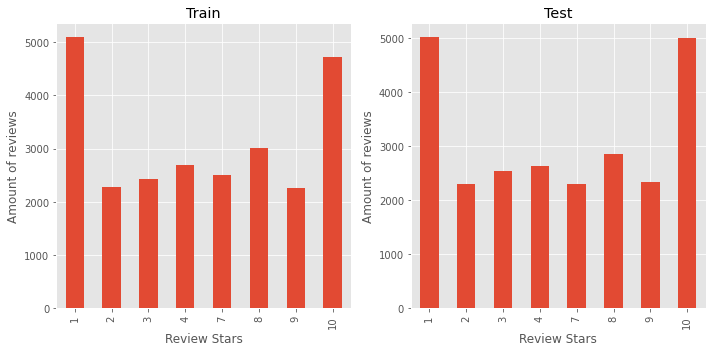

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_xlabel("Review Stars")
axs[0].set_ylabel("Amount of reviews")
train_val_count.plot(kind="bar",
                     title="Train",
                     figsize=(10,5),
                     ax=axs[0])
axs[1].set_xlabel("Review Stars")
axs[1].set_ylabel("Amount of reviews")
test_val_count.plot(kind="bar",
                    title="Test",
                    figsize=(10,5),
                    ax=axs[1])
plt.tight_layout()
plt.show()

## Basic NLTK

Just for the understanding of tokenization, part-of-speech-tagging (pos) and chunking, this is shown in this section.

#### Fetch an example

In [116]:
example_text = df["text"][0]
example_rating = df["rating"][0]
print({example_rating: example_text})

{3: "Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."}


#### Create tokens from the text

In [117]:
tokens = nltk.word_tokenize(example_text)
tokens[:10]

['Story', 'of', 'a', 'man', 'who', 'has', 'unnatural', 'feelings', 'for', 'a']

#### Tag each token with a part of speech tag, representing the word category

In [118]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Story', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('man', 'NN'),
 ('who', 'WP'),
 ('has', 'VBZ'),
 ('unnatural', 'JJ'),
 ('feelings', 'NNS'),
 ('for', 'IN'),
 ('a', 'DT')]

#### Group / chunk data

In [119]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Story/NN
  of/IN
  a/DT
  man/NN
  who/WP
  has/VBZ
  unnatural/JJ
  feelings/NNS
  for/IN
  a/DT
  pig/NN
  ./.
  Starts/VBZ
  out/RP
  with/IN
  a/DT
  opening/NN
  scene/NN
  that/WDT
  is/VBZ
  a/DT
  terrific/JJ
  example/NN
  of/IN
  absurd/JJ
  comedy/NN
  ./.
  A/DT
  formal/JJ
  orchestra/NN
  audience/NN
  is/VBZ
  turned/VBN
  into/IN
  an/DT
  insane/NN
  ,/,
  violent/JJ
  mob/NN
  by/IN
  the/DT
  crazy/JJ
  chantings/NNS
  of/IN
  it/PRP
  's/VBZ
  singers/NNS
  ./.
  Unfortunately/RB
  it/PRP
  stays/VBZ
  absurd/IN
  the/DT
  (ORGANIZATION WHOLE/NNP)
  time/NN
  with/IN
  no/DT
  general/JJ
  narrative/JJ
  eventually/RB
  making/VBG
  it/PRP
  just/RB
  too/RB
  off/RP
  putting/VBG
  ./.
  Even/RB
  those/DT
  from/IN
  the/DT
  era/NN
  should/MD
  be/VB
  turned/VBN
  off/RP
  ./.
  The/DT
  cryptic/JJ
  dialogue/NN
  would/MD
  make/VB
  (PERSON Shakespeare/NNP)
  seem/VB
  easy/JJ
  to/TO
  a/DT
  third/JJ
  grader/NN
  ./.
  On/IN
  a/DT
  technical/JJ
  le

## VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
 1. Stop words are removed (and, the, or etc.)
 2. each word is scored (how positive/neutral/negative)
 3. each score is combined to a total score

The result is a score telling how positive the text is, thus sentiment analysis.
    
Worth mentioning that this approach does not account for relationships between words, which is very important in human speech. At least it is a good start. 

### Imports

In [120]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

### Familiarize with sentiment intensity analyzer

In [121]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

Positive, neutral and negative values range from 0 to 1 in each value, and compound range from -1 to 1

### Back to our example

In [122]:
print(sia.polarity_scores(example_text))

{'neg': 0.108, 'neu': 0.746, 'pos': 0.146, 'compound': 0.7003}


2 star review

### Run the polarity score on entire dataset

In [123]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["text"]
        text_id = i
        vader_res = sia.polarity_scores(text)
        vader_res_rename = {}
        for key, value in vader_res.items():
            vader_res_rename[f"vader_{key}"] = value
        res[text_id] = vader_res_rename
    except RuntimeError:
        print(f"[ERROR] Broke for id {text_id}")

100%|██████████| 50000/50000 [02:01<00:00, 410.20it/s]


In [124]:
vaders = pd.DataFrame(res).T
vaders

,vader_neg,vader_neu,vader_pos,vader_compound
0,0.108,0.746,0.146,0.7003
1,0.159,0.704,0.136,-0.9697
2,0.047,0.846,0.108,0.7979
3,0.122,0.717,0.161,0.8791
4,0.151,0.743,0.106,-0.9663
...,...,...,...,...
49995,0.000,0.699,0.301,0.9908
49996,0.029,0.769,0.202,0.9730
49997,0.133,0.703,0.164,0.9773
49998,0.021,0.763,0.216,0.9907


### Merge with original dataframe

In [125]:
# vaders = vaders.reset_index().rename(columns={"index": "Id"})
# merged = vaders.merge(df, how="left")
# pd.merge(df, vaders, left_index=True, right_index=True, how='outer')
merged_vaders = pd.concat([df, vaders], axis=1)

### Print head

In [126]:
merged_vaders.head()

,rating,text,vader_neg,vader_neu,vader_pos,vader_compound
0,3,Story of a man who has unnatural feelings for ...,0.108,0.746,0.146,0.7003
1,4,Airport '77 starts as a brand new luxury 747 p...,0.159,0.704,0.136,-0.9697
2,4,This film lacked something I couldn't put my f...,0.047,0.846,0.108,0.7979
3,1,"Sorry everyone,,, I know this is supposed to b...",0.122,0.717,0.161,0.8791
4,1,When I was little my parents took me along to ...,0.151,0.743,0.106,-0.9663


### Plot VADER results

#### Sentiment vs stars given

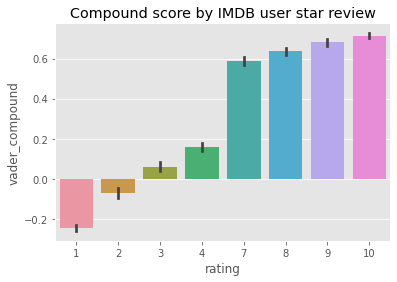

In [127]:
ax = sns.barplot(data=merged_vaders, x="rating", y="vader_compound")
ax.set_title("Compound score by IMDB user star review")
plt.show()

The more stars given, the better sentiment there is

#### Positive, neutral and negative score for each

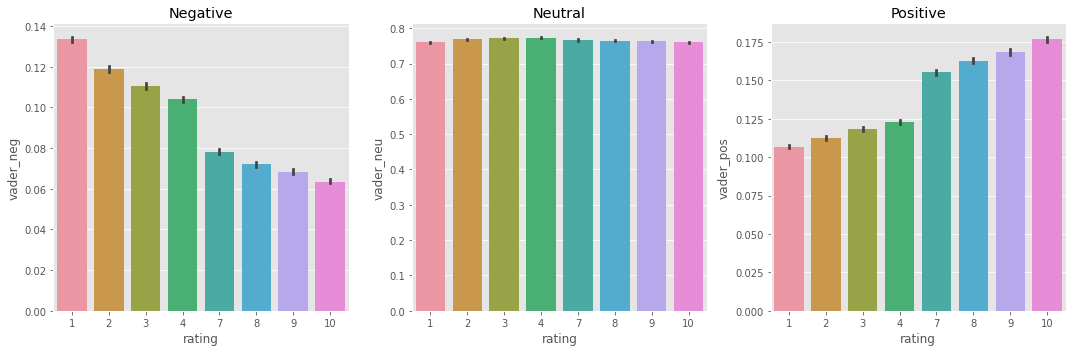

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("Negative")
sns.barplot(data=merged_vaders, x="rating", y="vader_neg", ax=axs[0])
axs[1].set_title("Neutral")
sns.barplot(data=merged_vaders, x="rating", y="vader_neu", ax=axs[1])
axs[2].set_title("Positive")
sns.barplot(data=merged_vaders, x="rating", y="vader_pos", ax=axs[2])
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

Context is important in human speech. For example sarcasm would make VADER inaccurate

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.


In [143]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [144]:
#MODEL = "../input/cardiffnlp/twitter-roberta-base-sentiment/model-dir" # Uploaded model downloaded offline as dataset
MODEL = "cardiffnlp/twitter-roberta-base-sentiment" # Uploaded model downloaded offline as dataset
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

### Roberta Model on example

In [147]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, truncation=True, return_tensors="pt", max_length=512).to(device)
    output = model(**encoded_text)
    scores = output[0][0].cpu().detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2],
    }
    return scores_dict

In [148]:
print({example_rating: example_text})
print(polarity_scores_roberta(example_text))

{3: "Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."}
{'roberta_neg': 0.46794543, 'roberta_neu': 0.34285566, 'roberta_pos': 0.1891989}


### Polarity score on entire dataset

In [149]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["text"]
        text_id = i
        res[text_id] = polarity_scores_roberta(text)
    except RuntimeError:
        print(f"[ERROR] Broke for id {text_id}")

100%|██████████| 50000/50000 [19:02<00:00, 43.78it/s]


In [150]:
roberta = pd.DataFrame(res).T
roberta

,roberta_neg,roberta_neu,roberta_pos
0,0.467945,0.342856,0.189199
1,0.162021,0.517641,0.320338
2,0.640916,0.306660,0.052424
3,0.580922,0.289530,0.129548
4,0.728336,0.224997,0.046667
...,...,...,...
49995,0.001823,0.011914,0.986262
49996,0.004465,0.028250,0.967285
49997,0.348896,0.545093,0.106011
49998,0.004231,0.037730,0.958039


### Merge with original dataframe

In [151]:
merged_roberta = pd.concat([df, roberta], axis=1)

## Plot

#### Positive, neutral and negative score for each

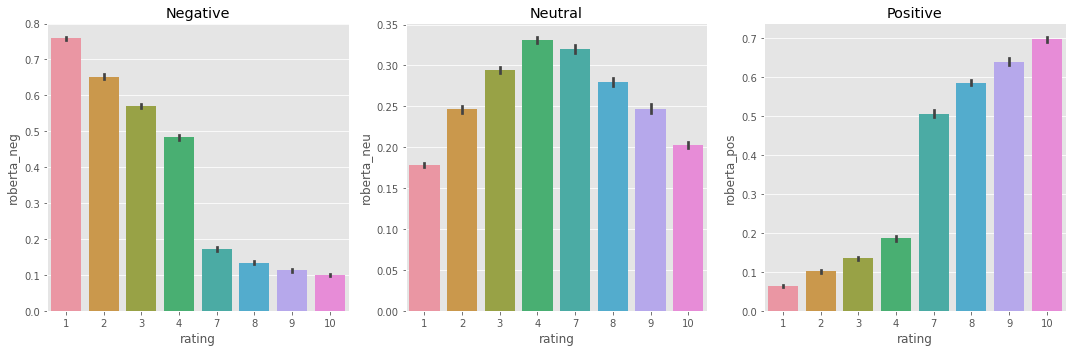

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("Negative")
sns.barplot(data=merged_roberta, x="rating", y="roberta_neg", ax=axs[0])
axs[1].set_title("Neutral")
sns.barplot(data=merged_roberta, x="rating", y="roberta_neu", ax=axs[1])
axs[2].set_title("Positive")
sns.barplot(data=merged_roberta, x="rating", y="roberta_pos", ax=axs[2])
plt.tight_layout()
plt.show()

## Combine all datasets

In [153]:
full_result_df = pd.concat([df, vaders, roberta], axis=1)

In [162]:
full_result_df.head()

,rating,text,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,3,Story of a man who has unnatural feelings for ...,0.108,0.746,0.146,0.7003,0.467945,0.342856,0.189199
1,4,Airport '77 starts as a brand new luxury 747 p...,0.159,0.704,0.136,-0.9697,0.162021,0.517641,0.320338
2,4,This film lacked something I couldn't put my f...,0.047,0.846,0.108,0.7979,0.640916,0.306660,0.052424
3,1,"Sorry everyone,,, I know this is supposed to b...",0.122,0.717,0.161,0.8791,0.580922,0.289530,0.129548
4,1,When I was little my parents took me along to ...,0.151,0.743,0.106,-0.9663,0.728336,0.224997,0.046667


### Save df to .csv for next pipeline

In [167]:
# Shuffle rows
# shuffled_df = full_result_df.sample(frac=1, random_state=1).reset_index(drop=True)
# print(shuffled_df.head())
# shuffled_df.to_csv(f"{DATA}/dataset/full_dataset_sentiment.csv", sep="█")

In [168]:
full_result_df.to_csv(f"{DATA}/dataset/full_dataset_sentiment.csv", sep="█")

In [171]:
dd = pd.read_csv(f"{DATA}/dataset/full_dataset_sentiment.csv", delimiter="█", engine="python", index_col=0)
dd.head()

,rating,text,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
49995,8,I was extraordinarily impressed by this film. ...,0.000,0.699,0.301,0.9908,0.001823,0.011914,0.986262
49996,10,"Although I'm not a golf fan, I attended a snea...",0.029,0.769,0.202,0.9730,0.004465,0.028250,0.967285
49997,8,"From the start of ""The Edge Of Love"", the view...",0.133,0.703,0.164,0.9773,0.348896,0.545093,0.106011
49998,10,"This movie, with all its complexity and subtle...",0.021,0.763,0.216,0.9907,0.004231,0.037730,0.958039
49999,7,I've seen this story before but my kids haven'...,0.070,0.641,0.289,0.9964,0.047472,0.278361,0.674167


## Plot

In [173]:
full_result_df.columns

Index(['rating', 'text', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

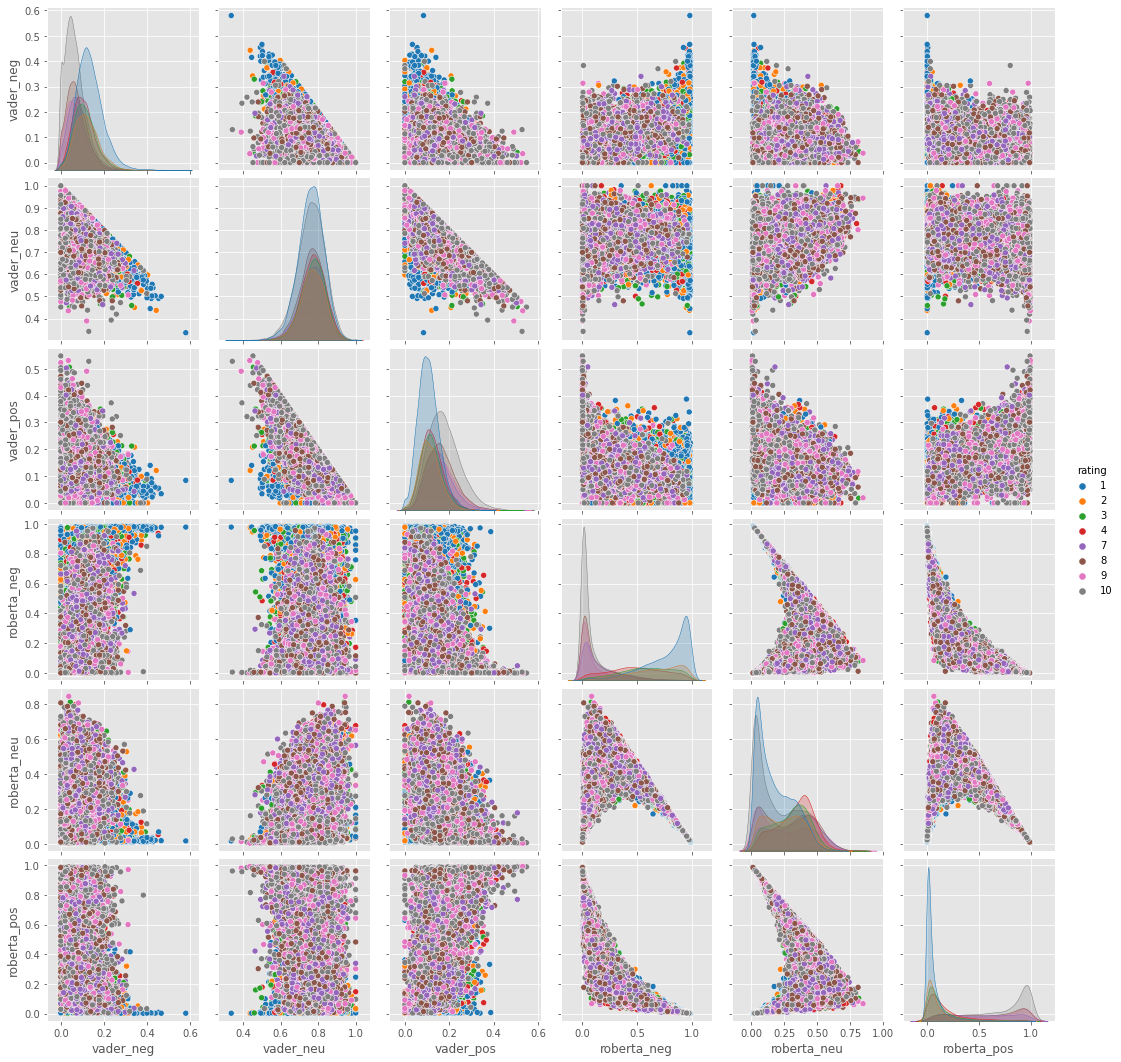

In [174]:
sns.pairplot(data=full_result_df,
            vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue="rating",
            palette="tab10")
plt.show()

## Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

### Most positive 1 star review

In [175]:
# Lets find the most positive 1 star review. I.e. its negative (score) but the model thought it was positive
full_result_df.query("rating == 1").sort_values("roberta_pos", ascending=False)["text"].values[0]

'This is definitely one of the best Kung fu movies in the history of Cinema. The screenplay is really well done (which is not often the case for this type of movies) and you can see that Chuck (in one of his first role)is a great actor. The final fight with the sherif deputy in the bullring is a masterpiece!'

In [176]:
# The same for the Vader BOW approach
full_result_df.query("rating == 1").sort_values("vader_pos", ascending=False)["text"].values[0]

'I rented "New Best Friend" hoping for a movie similar to enjoyable teen thrillers such as "Gossip" and "The Curve". Instead, "New Best Friend" is much more like "The In Crowd", in which there are no thrills and the acting is incredibly phony. "New Best Friend" is boring, and the events during the movie are the same. Skip this movie...it\'s a waste of time.'

### Most negative 10 star review

In [177]:
# We query the rows with a Score of 5 (5 star review), and sort values in a descending order getting the highest value first. 
# We then have the most negative value as the first element
full_result_df.query("rating == 10").sort_values("roberta_neg", ascending=False)["text"].values[0]

'OK. Who ever invented this film hates humanity and wants to see them all slit their throats. This "film" was absolute and utter filth. What the heck was up with the weird old bags eyes? Seriously, was she on some sort of horrible drug and then she like just thought she could control people? She was running around with her freaking evil eye and it was like what? Do I have a booger hanging out of my nose? What are you staring at? Are you like the sea witch or something? All and all though I thought the graphics were top notch old chap. For that alone I would give it a ten. But just cover your ears when you are watching it. The pure and complete evil that comes from that film will make your ears bleed and your eyelids fall off. Who knows? You might even get a knot in your small intestine. You better watch out fools.'

In [178]:
# We query the rows with a Score of 5 (5 star review), and sort values in a descending order getting the highest value first. 
# We then have the most negative value as the first element
full_result_df.query("rating == 10").sort_values("vader_neg", ascending=False)["text"].values[0]

"I watched this film early 70's.It is the best film I have ever watched And I will never forget it as long as I live. I hate wars. I hate wars. I hate wars. I wonder why we humans still let wars happen. Do you? Do you know why all these wars go on and on and on? innocent people get killed, even today, for stupid and unreal rezone ? I watched this film early 70's.It is the best film I have ever watched And I will never forget it as long as I live. I hate wars. I hate wars. I hate wars. I wonder why we humans still let wars happen. Do you? Do you know why all these wars go on and on and on? innocent people get killed, even today, for stupid and unreal rezone ? I watched this film early 70's.It is the best film I have ever watched And I will never forget it as long as I live. I hate wars. I hate wars. I hate wars. I wonder why we humans still let wars happen. Do you? Do you know why all these wars go on and on and on? innocent people get killed, even today, for stupid and unreal rezone ?"

## Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

Everything is downloaded for you and you can run sentiment analysis in just two lines of code.

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

In [ ]:
sentiment_pipeline("ok, so do we need to kill them too or are the slavs okay ? for some reason whenever i hear the word slav , the word slobber comes to mind and i picture a slobbering half breed creature like the humpback of notre dame or Igor haha")

In [ ]:
sentiment_pipeline("Jonas has a big penis!")

In [ ]:
sentiment_pipeline("this is ass, but still good")

A special thanks to [Rob Mulla](https://www.kaggle.com/robikscube) for his notebook on the matter.